## IMPORT LIBRARY

In [51]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
from collections import Counter
from PIL import Image
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
#------------------------------------- 
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from scipy import stats 
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

## DATA 준비

### data load

In [89]:
path = '../data/'
#Importing Datasets
df_item = pd.read_csv(path+"olist_order_items_dataset.csv")
df_reviews = pd.read_csv(path+"olist_order_reviews_dataset.csv")
df_orders = pd.read_csv(path+"olist_orders_dataset.csv")
df_products = pd.read_csv(path+"olist_products_dataset.csv")
df_geolocation = pd.read_csv(path+"olist_geolocation_dataset.csv")
df_sellers = pd.read_csv(path+"olist_sellers_dataset.csv")
df_order_pay = pd.read_csv(path+"olist_order_payments_dataset.csv")
df_customers = pd.read_csv(path+"olist_customers_dataset.csv")
df_category = pd.read_csv(path+"product_category_name_translation.csv")

In [7]:
df_list = [df_customers, df_item, df_order_pay, df_reviews, df_orders, df_products, df_sellers, df_geolocation, df_category]

In [6]:
for x in df_list:
    print(x.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm

### data merge

In [90]:
# Merging Datasets
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

data columns 설명   

[df_customer]   
<U>***customer_id : 주문 데이터 세트의 키입니다. 각 주문에는 고유한 customer_id가 있습니다.***</U>   
customer_unique_id : 고객의 고유 식별자.    
customer_zip_code_prefix : 고객 우편번호의 처음 5자리   
customer_city : 고객 도시 이름  
customer_state : 고객 주    

[df_item]   
<U>***order_id : 고유 식별자 주문***</U>   
order_item_id : 동일한 주문에 포함된 품목의 번호를 식별하는 순차적인 번호.      
<U>***product_id : 제품 고유 식별자***</U>      
<U>***seller_id : 판매자 고유 식별자***</U>     
shipping_limit_date : 주문을 물류 파트너에게 처리하기 위한 판매자의 배송 제한 날짜를 보여줍니다.    
price : 품목 가격   
freight_value : 품목 운임 가치 품목(주문에 품목이 두 개 이상 있는 경우 운임 가치는 품목 간에 분할됨)    

[df_order_pay]  
<U>***order_id : 주문의 고유 식별자.***</U>     
payment_sequential : 고객은 두 개 이상의 결제 방법으로 주문을 결제할 수 있습니다. 그렇게 하면 모든 결제를 수용할 수 있는 시퀀스가 ​​생성됩니다.     
payment_type : 고객이 선택한 결제 방법.     
payment_installments : 고객이 선택한 할부 횟수.     
payment_value : 거래 가치.      

[df_reviews]
review_id : 고유 리뷰 식별자    
<U>***order_id : 고유 주문 식별자***</U>        
review_score : 만족도 조사에서 고객이 준 1~5점의 점수입니다.    
review_comment_title : 고객이 포르투갈어로 남긴 리뷰의 댓글 제목입니다.     
review_comment_message : 고객이 남긴 리뷰의 포르투갈어 코멘트 메시지입니다.     
review_creation_date : 만족도 설문 조사가 고객에게 전송된 날짜를 보여줍니다.        
review_answer_timestamp : 만족도 설문 답변 타임스탬프를 보여줍니다.     

[df_orders]     
<U>***order_id : 주문의 고유 식별자.***</U>        
<U>***customer_id : 고객 데이터 세트의 키. 각 주문에는 고유한 customer_id가 있습니다.***</U>             
order_status : 주문 상태(배달됨, 발송됨 등)에 대한 참조입니다.      
order_purchase_timestamp : 구매 타임스탬프를 보여줍니다.        
order_approved_at : 결제 승인 타임스탬프를 보여줍니다.      
order_delivered_carrier_date : 주문 게시 타임스탬프를 보여줍니다. 물류 파트너에게 처리된 시점입니다.    
order_delivered_customer_date : 고객에게 실제 주문 배송 날짜를 보여줍니다.      
order_estimated_delivery_date : 구매 시점에 고객에게 안내된 예상 배송일을 보여줍니다.   

[df_products]   
<U>***product_id : 고유 제품 식별자***</U>      
product_category_name : 포르투갈어로 제품의 핵심 카테고리입니다.    
product_name_lenght : 제품명에서 추출된 문자 수입니다.      
product_description_lenght : 제품 설명에서 추출된 문자 수입니다.    
product_photos_qty : 제품 게시 사진 수      
product_weight_g : 제품 무게는 그램 단위로 측정됩니다.      
product_length_cm : 제품 길이는 센티미터로 측정합니다.      
product_height_cm : 제품 높이는 센티미터로 측정합니다.      
product_width_cm : 제품의 너비는 센티미터로 측정됩니다.     

[df_sellers]    
<U>***seller_id : 판매자 고유 식별자***</U>         
seller_zip_code_prefix : 판매자 우편번호의 처음 5자리   
seller_city : 판매자 도시 이름  
seller_state : 판매자 주    


df_geolocation, df_category 두 데이터는 결합 제거

### product name 영어로 바꾸기

In [91]:
df_category_origin=pd.DataFrame(df_train['product_category_name'].unique(), columns=['product_category_name'])
len(df_category_origin)

74

In [92]:
len(df_category)

71

실제 사용하는 train dataframe에서는 category_name이 73개가 존재하지만 df_category에는 71개가 존재   
교집합 여부 확인 후 교집합일 경우 누락되어 있는 데이터 찾기 

In [93]:
df_category_ch = pd.DataFrame(df_category['product_category_name'])

In [94]:
df_check = pd.merge(df_category_origin,df_category_ch, how = 'outer', indicator = True)

In [78]:
df_check.query('_merge == "left_only"').drop(columns='_merge')

,product_category_name
60,pc_gamer
65,portateis_cozinha_e_preparadores_de_alimentos
73,NaN


#### 번역 딕셔너리

In [95]:
translation_dic = {}
for i  in range(len(df_category)):
    translation_dic[df_category.iloc[i,0]] = df_category.iloc[i,1]
translation_dic

{'beleza_saude': 'health_beauty',
 'informatica_acessorios': 'computers_accessories',
 'automotivo': 'auto',
 'cama_mesa_banho': 'bed_bath_table',
 'moveis_decoracao': 'furniture_decor',
 'esporte_lazer': 'sports_leisure',
 'perfumaria': 'perfumery',
 'utilidades_domesticas': 'housewares',
 'telefonia': 'telephony',
 'relogios_presentes': 'watches_gifts',
 'alimentos_bebidas': 'food_drink',
 'bebes': 'baby',
 'papelaria': 'stationery',
 'tablets_impressao_imagem': 'tablets_printing_image',
 'brinquedos': 'toys',
 'telefonia_fixa': 'fixed_telephony',
 'ferramentas_jardim': 'garden_tools',
 'fashion_bolsas_e_acessorios': 'fashion_bags_accessories',
 'eletroportateis': 'small_appliances',
 'consoles_games': 'consoles_games',
 'audio': 'audio',
 'fashion_calcados': 'fashion_shoes',
 'cool_stuff': 'cool_stuff',
 'malas_acessorios': 'luggage_accessories',
 'climatizacao': 'air_conditioning',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'moveis_cozinha_area_de_ser

#### df_category에 없는 product name 추가하기

In [96]:
len(translation_dic.keys())

71

In [97]:
translation_dic['portateis_cozinha_e_preparadores_de_alimentos'] = 'kitchen_portals_and_food_preparators'
translation_dic['pc_gamer'] = 'pc_gamer'


In [98]:
len(translation_dic.keys())

73

#### product name 포르투칼어 -> 영어

In [110]:
for i in tqdm(range(len(df_train))):
    if not pd.isnull(df_train.loc[i, 'product_category_name']):
        df_train.loc[i, 'product_category_name'] = translation_dic[df_train.loc[i, 'product_category_name']]
    else:
        pass

100%|██████████| 119143/119143 [02:23<00:00, 827.65it/s] 


In [111]:
df_train['product_category_name'].unique()

array(['small_appliances', 'garden_tools',
       'construction_tools_construction', 'sports_leisure',
       'furniture_decor', nan, 'bed_bath_table', 'housewares',
       'health_beauty', 'fashion_bags_accessories',
       'furniture_mattress_and_upholstery', 'computers_accessories',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_tools', 'fashion_shoes', 'baby', 'stationery',
       'signaling_and_security', 'cool_stuff', 'home_appliances_2',
       'air_conditioning', 'home_appliances', 'watches_gifts', 'toys',
       'home_construction', 'market_place', 'musical_instruments',
       'telephony', 'luggage_accessories', 'perfumery', 'dvds_blu_ray',
       'music', 'auto', 'consoles_games', 'food', 'arts_and_craftmanship',
       'electronics', 'audio', 'home_comfort_2',
       'agro_industry_and_commerce', 'construction_tools_safety',
       'pet_shop', 'construction_tools_lights', 'food_drink',
       'costruction_tools_garden', 'computers', 'furniture_l

In [112]:
df_train.shape

(119143, 39)

In [115]:
df_train.to_csv('../data/train.csv',index=False)

In [ ]:
df_train = pd.read_csv('data/train.csv')

## 결측치 확인

In [116]:
df_train.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


### 1. 주문 상태가 'cancelled' 또는 'unshipped'이고 'order_delivered_customer_date'가 Null인 행을 확인


In [117]:
cancelled_unshipped_null_delivery = df_train[(df_train['order_status'].isin(['cancelled', 'unshipped'])) & (df_train['order_delivered_customer_date'].isnull())]
print(f"'order_status'가 'cancelled' 또는 'unshipped'이고 'order_delivered_customer_date'가 Null인 행 개수: {cancelled_unshipped_null_delivery.shape[0]}")


'order_status'가 'cancelled' 또는 'unshipped'이고 'order_delivered_customer_date'가 Null인 행 개수: 0


### 2. 금액 관련 필드 Null 값 확인: 'price' 또는 'freight_value'가 Null인 행을 확인

In [118]:
null_price_freight = df_train[df_train[['price', 'freight_value']].isnull().any(axis=1)]
print(f"'price' 또는 'freight_value'가 Null인 행 개수: {null_price_freight.shape[0]}")


'price' 또는 'freight_value'가 Null인 행 개수: 833


결측치 처리: 'price' 또는 'freight_value'가 Null인 경우 해당 행 제거

In [119]:
df_train = df_train.dropna(subset=['price', 'freight_value'])

### 3. 결제 정보가 Null인 행 확인: 'payment_value'가 Null인 행을 확인

In [120]:
null_payment_value = df_train[df_train['payment_value'].isnull()]
print(f"'payment_value'가 Null인 행 개수: {null_payment_value.shape[0]}")

'payment_value'가 Null인 행 개수: 3


결측치 처리: 결제 정보가 Null인 경우 해당 행 제거

In [121]:
df_train = df_train.dropna(subset=['payment_value'])

### 4. 리뷰가 Null인 주문 확인: 'review_score'와 'review_comment_message'가 모두 Null인 행을 확인


In [122]:
null_review_info = df_train[df_train[['review_score', 'review_comment_message']].isnull().all(axis=1)]
print(f"'review_score'와 'review_comment_message'가 모두 Null인 행 개수: {null_review_info.shape[0]}")


'review_score'와 'review_comment_message'가 모두 Null인 행 개수: 978


보류

### 5. 제품 속성 관련 Null 값 확인: 제품 관련 카테고리 이름 또는 무게 중 하나라도 Null인 행 확인

In [123]:
null_product_features = df_train[df_train[['product_category_name', 'product_weight_g']].isnull().any(axis=1)]
print(f"제품 속성 중 하나라도 Null인 행 개수: {null_product_features.shape[0]}")

제품 속성 중 하나라도 Null인 행 개수: 1710


In [124]:
null_product_features = df_train[df_train[['product_weight_g']].isnull().any(axis=1)]
print(f"제품 무게 Null인 행 개수: {null_product_features.shape[0]}")

제품 무게 Null인 행 개수: 20


In [125]:
null_product_features = df_train[df_train[['product_category_name']].isnull().any(axis=1)]
print(f"제품 이름 Null인 행 개수: {null_product_features.shape[0]}")

제품 이름 Null인 행 개수: 1709


결측치 처리: Null 값을 가진 행을 제거

In [126]:
df_train = df_train.dropna(subset=['product_category_name', 'product_weight_g'])

### 6. 고객 위치 정보가 Null인 경우 확인: 'customer_zip_code_prefix' 또는 'customer_city'가 Null인 행


In [127]:
null_customer_location = df_train[df_train[['customer_zip_code_prefix', 'customer_city']].isnull().any(axis=1)]
print(f"'customer_zip_code_prefix' 또는 'customer_city'가 Null인 행 개수: {null_customer_location.shape[0]}")


'customer_zip_code_prefix' 또는 'customer_city'가 Null인 행 개수: 0


### 7. 판매자 위치 정보가 Null인 경우 확인: 'seller_zip_code_prefix' 또는 'seller_city'가 Null인 행


In [128]:
null_seller_location = df_train[df_train[['seller_zip_code_prefix', 'seller_city']].isnull().any(axis=1)]
print(f"'seller_zip_code_prefix' 또는 'seller_city'가 Null인 행 개수: {null_seller_location.shape[0]}")


'seller_zip_code_prefix' 또는 'seller_city'가 Null인 행 개수: 0


### 8.결측치 확인

In [129]:
# 최종 데이터 확인
print("\n결측치 처리 후 데이터 프레임의 결측치 개수:\n", df_train.isnull().sum())


결측치 처리 후 데이터 프레임의 결측치 개수:
 order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1215
order_delivered_customer_date      2517
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                           964
review_score                        964
review_comment_title             102787
review_comment_message            67679
review_creation_date                964
review_answer_timestamp             964
product_cate

### 9.order_status에 따른 결측치 재확인

In [130]:
null_approved_status = df_train[df_train['order_approved_at'].isnull()]['order_status']
print("order_approved_at 값이 NULL일 때의 order_status 분포:\n")
print(null_approved_status.value_counts())

order_approved_at 값이 NULL일 때의 order_status 분포:

order_status
delivered    14
Name: count, dtype: int64


1) delivered: 고객에게 주문이 완료되어 배송된 상태  
처리 방안: 이 상태에서는 order_approved_at, order_delivered_carrier_date, order_delivered_customer_date 모두 값이 있어야 함.

In [131]:
# 'delivered' 상태에서 필요한 값이 Null인 경우 확인 및 제거
delivered_null = df_train[(df_train['order_status'] == 'delivered') & (df_train[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isnull().any(axis=1))]
print(f"'delivered' 상태에서 필요한 값이 Null인 행 개수: {delivered_null.shape[0]}")

'delivered' 상태에서 필요한 값이 Null인 행 개수: 23


In [132]:
df_train = df_train[~((df_train['order_status'] == 'delivered') & (df_train[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isnull().any(axis=1)))]

2. shipped: 주문이 발송되었으나 아직 고객에게 도착하지 않은 상태입니다.     
처리 방안: order_approved_at과 order_delivered_carrier_date는 값이 있어야 하며, order_delivered_customer_date는 Null일 수 있습니다.

In [133]:
shipped_null = df_train[(df_train['order_status'] == 'shipped') & (df_train[['order_approved_at', 'order_delivered_carrier_date']].isnull().any(axis=1))]
print(f"'shipped' 상태에서 필요한 값이 Null인 행 개수: {shipped_null.shape[0]}")

'shipped' 상태에서 필요한 값이 Null인 행 개수: 0


3. approved: 결제가 승인된 상태이며, 아직 배송은 시작되지 않은 상태입니다.  
처리 방안: order_approved_at은 값이 있어야 하며, order_delivered_carrier_date와 order_delivered_customer_date는 Null일 수 있습니다.

In [134]:
approved_null = df_train[(df_train['order_status'] == 'approved') & (df_train['order_approved_at'].isnull())]
print(f"'approved' 상태에서 'order_approved_at'이 Null인 행 개수: {approved_null.shape[0]}")

'approved' 상태에서 'order_approved_at'이 Null인 행 개수: 0


In [135]:
# 최종 데이터 확인
print("\n결측치 처리 후 데이터 프레임의 결측치 개수:\n", df_train.isnull().sum())


결측치 처리 후 데이터 프레임의 결측치 개수:
 order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date       1213
order_delivered_customer_date      2509
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                           964
review_score                        964
review_comment_title             102768
review_comment_message            67669
review_creation_date                964
review_answer_timestamp             964
product_cate

review part 제외 결측치 처리 완료

## EDA

기본 통계량:
                price  freight_value  payment_value
count  116574.000000  116574.000000  116574.000000
mean      120.753475      20.062331     172.916475
std       183.831620      15.846216     267.619058
min         0.850000       0.000000       0.000000
25%        39.900000      13.080000      61.000000
50%        74.900000      16.320000     108.185000
75%       134.900000      21.220000     189.720000
max      6735.000000     409.680000   13664.080000


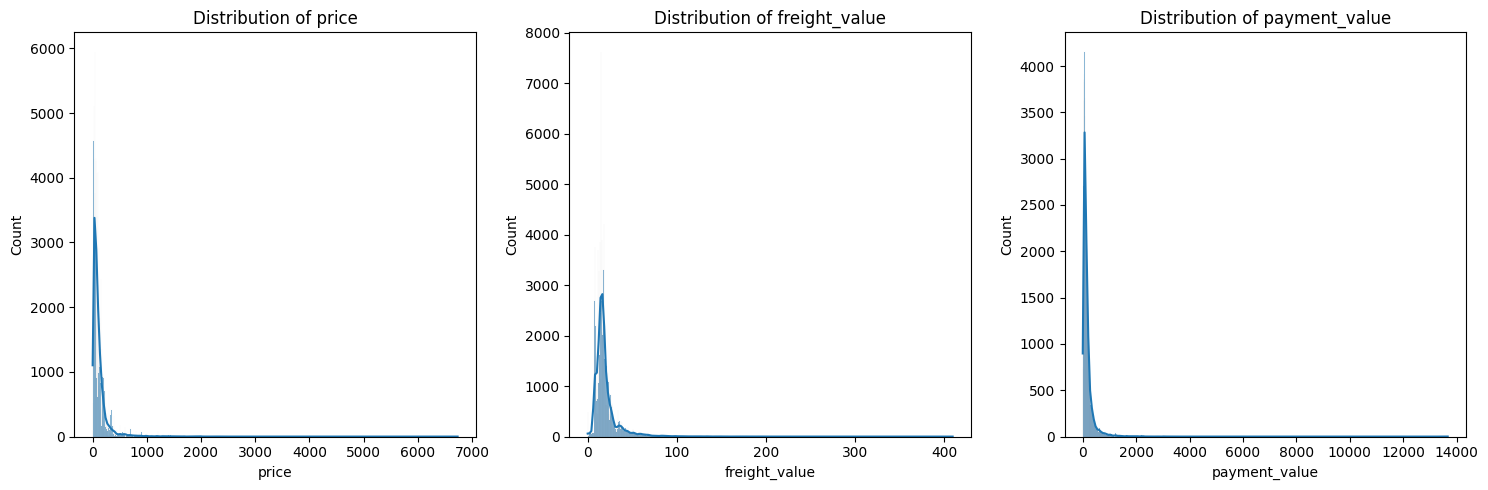

In [136]:
# 금액 관련 칼럼의 기본 통계량 확인
stats_price = df_train[['price', 'freight_value', 'payment_value']].describe()
print("기본 통계량:\n", stats_price)

# 시각화 - 금액 관련 분포 확인
plt.figure(figsize=(15, 5))
for i, col in enumerate(['price', 'freight_value', 'payment_value']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

구매 빈도 상위 고객:
 customer_id
270c23a11d024a44c896d1894b261a83    63
13aa59158da63ba0e93ec6ac2c07aacb    38
9af2372a1e49340278e7c1ef8d749f34    29
92cd3ec6e2d643d4ebd0e3d6238f69e2    26
d22f25a9fadfb1abbc2e29395b1239f4    24
Name: count, dtype: int64
누적 구매 금액 상위 고객:
 customer_id
1617b1357756262bfa56ab541c47bc16    109312.64
bd5d39761aa56689a265d95d8d32b8be     45256.00
be1b70680b9f9694d8c70f41fa3dc92b     44048.00
05455dfa7cd02f13d132aa7a6a9729c6     36489.24
1ff773612ab8934db89fd5afa8afe506     30186.00
Name: payment_value, dtype: float64


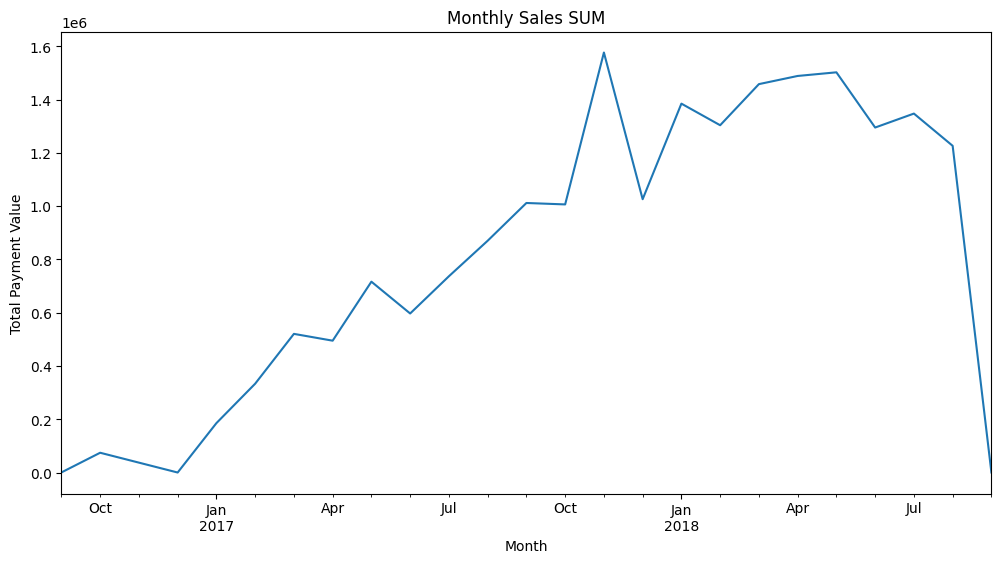

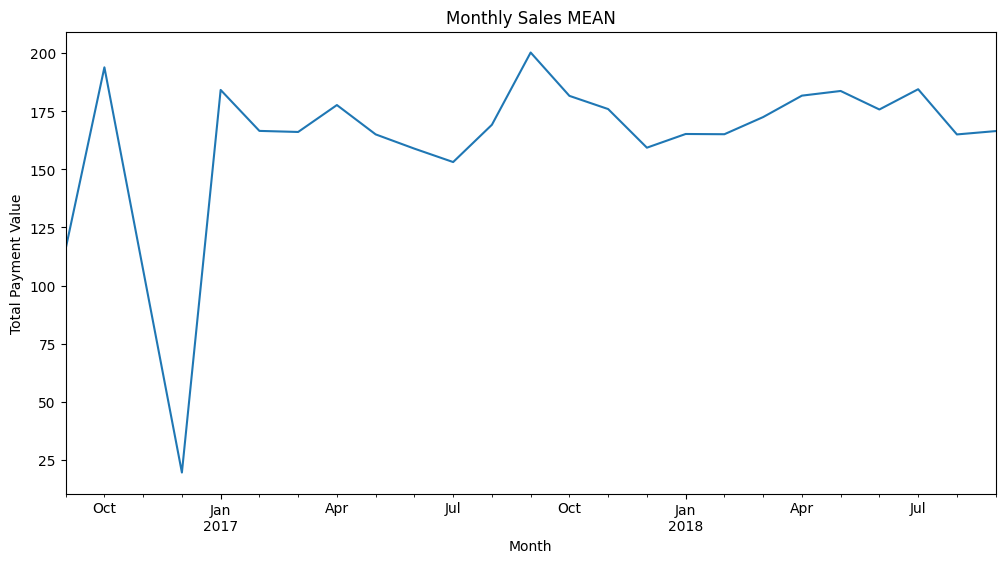

In [141]:
# 고객별 구매 빈도 계산
purchase_frequency = df_train['customer_id'].value_counts()
print("구매 빈도 상위 고객:\n", purchase_frequency.head())

# 고객별 누적 구매 금액 계산
customer_spend = df_train.groupby('customer_id')['payment_value'].sum().sort_values(ascending=False)
print("누적 구매 금액 상위 고객:\n", customer_spend.head())

# 시각화 - 월별 구매 패턴 분석
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'], errors='coerce')
df_train['purchase_month'] = df_train['order_purchase_timestamp'].dt.to_period('M')
monthly_sales_sum = df_train.groupby('purchase_month')['payment_value'].sum()

plt.figure(figsize=(12, 6))
monthly_sales_sum.plot()
plt.title('Monthly Sales SUM')
plt.xlabel('Month')
plt.ylabel('Total Payment Value')
plt.show()
monthly_sales_mean = df_train.groupby('purchase_month')['payment_value'].mean()

plt.figure(figsize=(12, 6))
monthly_sales_mean.plot()
plt.title('Monthly Sales MEAN')
plt.xlabel('Month')
plt.ylabel('Total Payment Value')
plt.show()

결제 방법 분포:
 payment_type
credit_card    86008
boleto         22685
voucher         6212
debit_card      1669
Name: count, dtype: int64


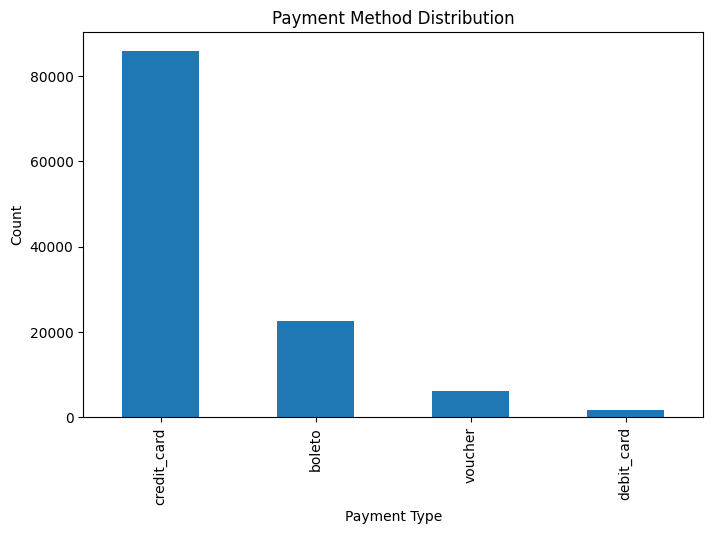

할부 사용 분포:
 payment_installments
0.0         3
1.0     58028
2.0     13514
3.0     11655
4.0      7923
5.0      5982
6.0      4588
7.0      1804
8.0      5054
9.0       724
10.0     6865
11.0       25
12.0      166
13.0       19
14.0       16
15.0       93
16.0        7
17.0        7
18.0       38
20.0       21
21.0        6
22.0        1
23.0        1
24.0       34
Name: count, dtype: int64


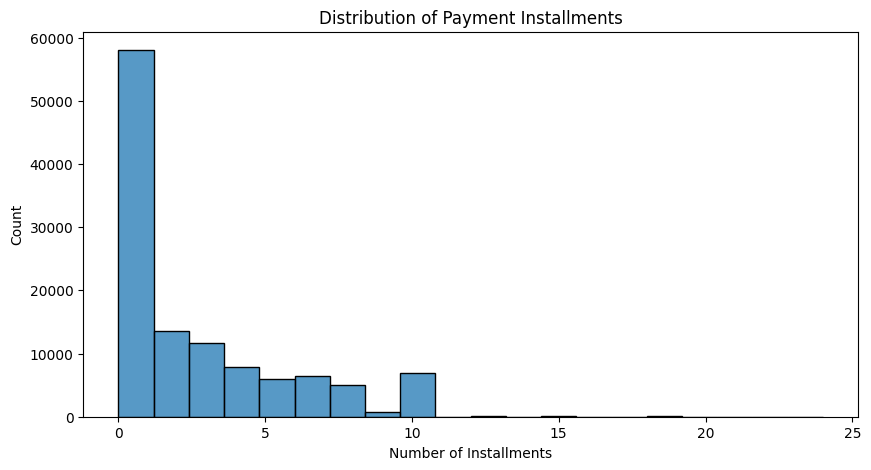

In [138]:
# 결제 방법 분석
payment_type_counts = df_train['payment_type'].value_counts()
print("결제 방법 분포:\n", payment_type_counts)

# 시각화 - 결제 방법 분포
plt.figure(figsize=(8, 5))
payment_type_counts.plot(kind='bar')
plt.title('Payment Method Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

# 할부 사용 분석
installment_usage = df_train['payment_installments'].value_counts().sort_index()
print("할부 사용 분포:\n", installment_usage)

# 시각화 - 할부 사용 분포
plt.figure(figsize=(10, 5))
sns.histplot(df_train['payment_installments'], kde=False, bins=20)
plt.title('Distribution of Payment Installments')
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.show()

할부 사용자들 (number of installments > 0) 결제 방식 비율


리뷰 점수 분포:
 review_score
1.0    14552
2.0     4021
3.0     9720
4.0    21951
5.0    65366
Name: count, dtype: int64


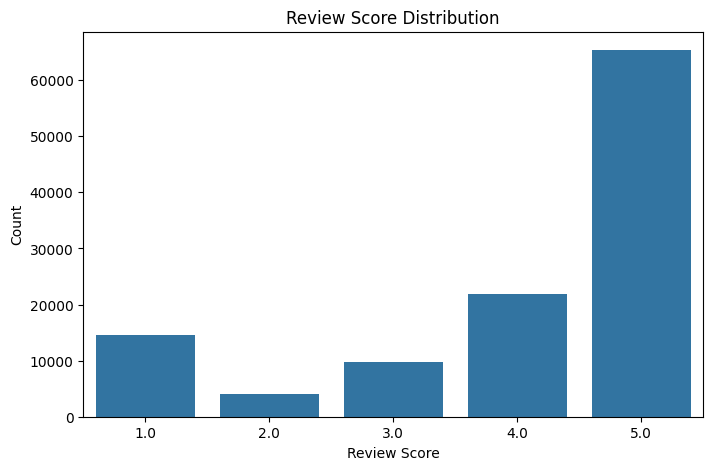

리뷰 길이 통계량:
 count      208.000000
mean       560.451923
std       4678.827512
min          1.000000
25%         93.750000
50%        172.000000
75%        387.000000
max      67669.000000
Name: count, dtype: float64
리뷰 길이 분포:
 review_comment_message
0.0      67669
1.0        113
2.0        237
3.0        517
4.0        145
         ...  
203.0       28
204.0       17
205.0        1
207.0        1
208.0        1
Name: count, Length: 208, dtype: int64


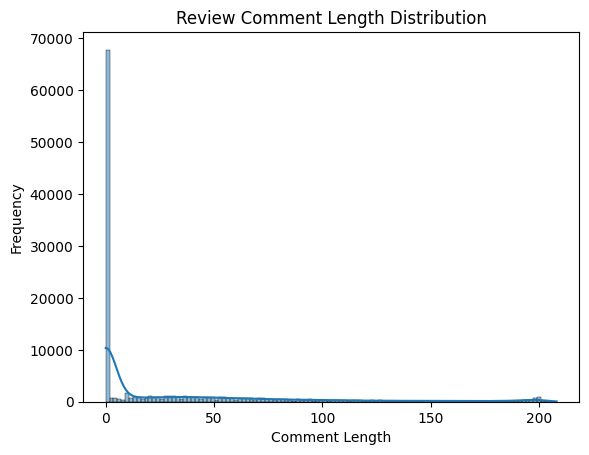

In [146]:
# 리뷰 점수 분포
review_scores = df_train['review_score'].value_counts().sort_index()
print("리뷰 점수 분포:\n", review_scores)

# 시각화 - 리뷰 점수 분포
plt.figure(figsize=(8, 5))
sns.countplot(x='review_score', data=df_train, order=review_scores.index)
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

# 리뷰 코멘트 길이 분석
review_comment_len = df_train['review_comment_message'].str.len().fillna(0).value_counts().sort_index()
print("리뷰 길이 통계량:\n", review_comment_len.describe())
print("리뷰 길이 분포:\n", review_comment_len)
df_train['comment_length'] = df_train['review_comment_message'].str.len().fillna(0)
sns.histplot(df_train['comment_length'], kde=True)
plt.title('Review Comment Length Distribution')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

코멘트 쓰는 전체 비율   
코멘트 쓰는 사람들 한번 이상 쓴 사람들 비율     
한번 이상 쓴 사람들 중 다수 쓴 사람들 비율

카테고리별 매출 상위:
 product_category_name
bed_bath_table           1743841.61
health_beauty            1662963.59
computers_accessories    1599360.94
furniture_decor          1443468.72
watches_gifts            1430237.34
Name: payment_value, dtype: float64


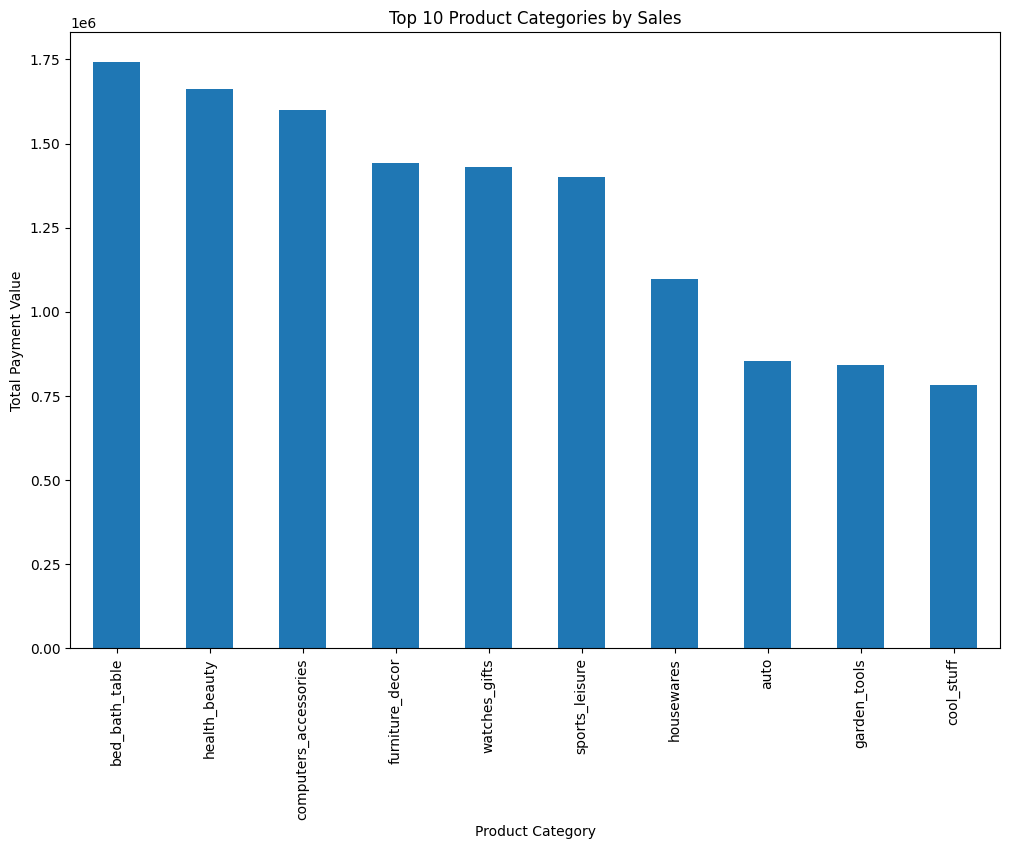

카테고리별 매출 하위:
 product_category_name
security_and_services         324.51
fashion_childrens_clothes     785.67
cds_dvds_musicals            1199.43
home_comfort_2               1710.54
pc_gamer                     2174.43
Name: payment_value, dtype: float64


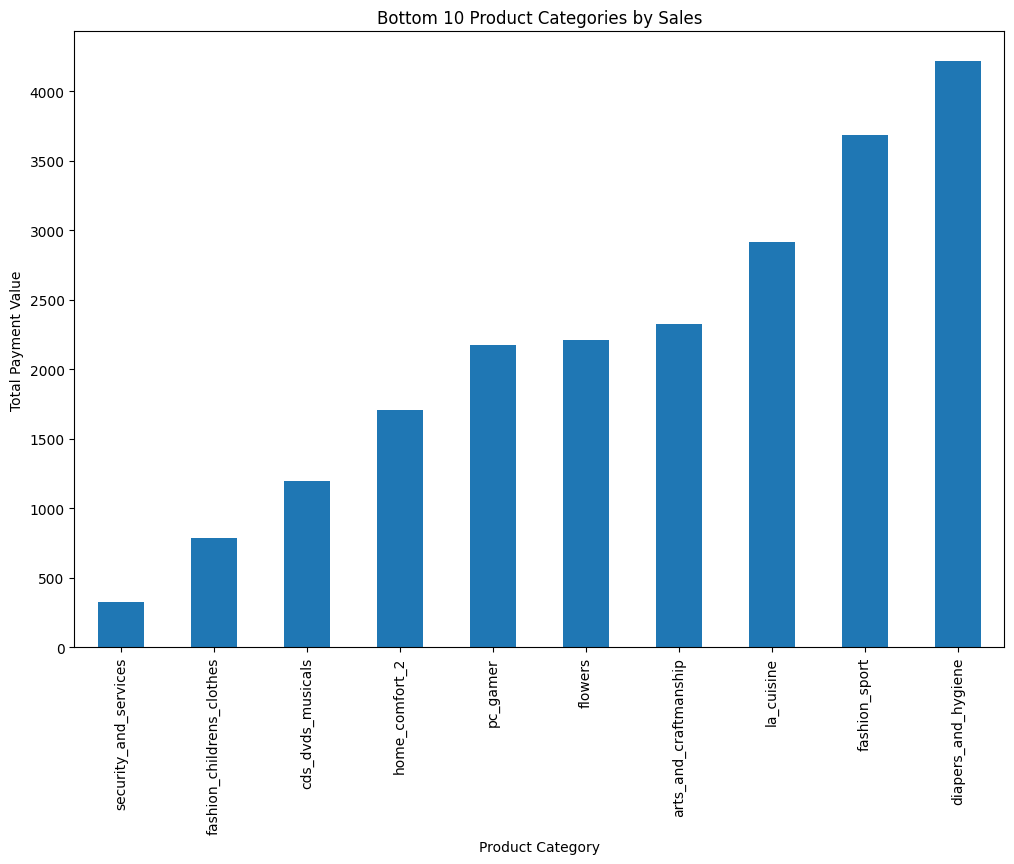

In [148]:
# 제품 카테고리별 매출
category_sales_top = df_train.groupby('product_category_name')['payment_value'].sum().sort_values(ascending=False)
print("카테고리별 매출 상위:\n", category_sales_top.head())

# 시각화 - 제품 카테고리별 매출
plt.figure(figsize=(12, 8))
category_sales_top.head(10).plot(kind='bar')
plt.title('Top 10 Product Categories by Sales')
plt.xlabel('Product Category')
plt.ylabel('Total Payment Value')
plt.show()

# 제품 카테고리별 매출
category_sales_bottom = df_train.groupby('product_category_name')['payment_value'].sum().sort_values(ascending=True)
print("카테고리별 매출 하위:\n", category_sales_bottom.head())

# 시각화 - 제품 카테고리별 매출
plt.figure(figsize=(12, 8))
category_sales_bottom.head(10).plot(kind='bar')
plt.title('Bottom 10 Product Categories by Sales')
plt.xlabel('Product Category')
plt.ylabel('Total Payment Value')
plt.show()

배송 지연 건수: 7437


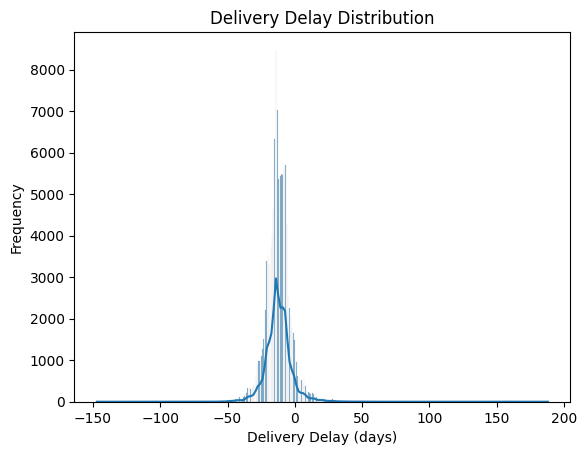

In [150]:
# 배송 지연 분석
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'], errors='coerce')
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date'], errors='coerce')

df_train['delivery_delay'] = (df_train['order_delivered_customer_date'] - df_train['order_estimated_delivery_date']).dt.days
delayed_deliveries = df_train[df_train['delivery_delay'] > 0]
delay_count = delayed_deliveries.shape[0]
print(f"배송 지연 건수: {delay_count}")

# 시각화 - 배송 지연 분포
sns.histplot(df_train['delivery_delay'].dropna(), kde=True)
plt.title('Delivery Delay Distribution')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Frequency')
plt.show()

상관 관계:
                   price  freight_value  review_score
price          1.000000       0.416756     -0.005063
freight_value  0.416756       1.000000     -0.038218
review_score  -0.005063      -0.038218      1.000000


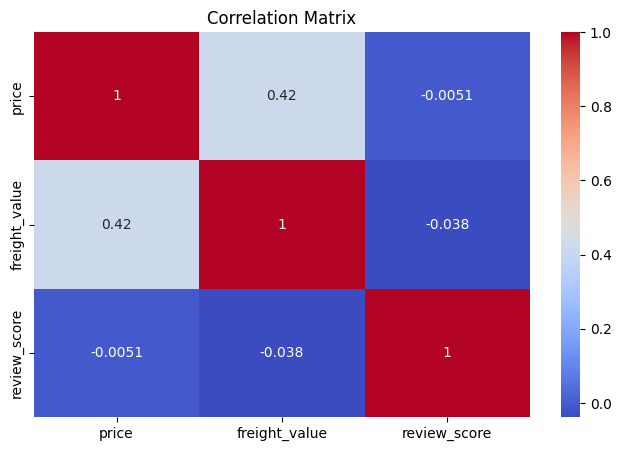

피벗 테이블:
 payment_type                  boleto  credit_card  debit_card  voucher
product_category_name                                                 
agro_industry_and_commerce  54411.43     61173.89     1625.04  1520.25
air_conditioning            17530.84     71498.07      819.33  1322.42
art                         12104.96     17460.66      665.97   761.34
arts_and_craftmanship         770.40      1365.82      189.95      NaN
audio                        9884.74     47403.17     1023.85  2076.86


In [153]:
# 상관 관계 분석
corr = df_train[['price', 'freight_value', 'review_score']].corr()
print("상관 관계:\n", corr)

# 히트맵으로 시각화
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 피벗 테이블 - 제품 카테고리별 구매 빈도와 결제 유형별 구매 금액
pivot_table = df_train.pivot_table(values='payment_value', index='product_category_name', columns='payment_type', aggfunc='sum')
print("피벗 테이블:\n", pivot_table.head())

In [165]:
df_train['order_purchase_timestamp']

0        2017-09-26 22:17:05
1        2017-10-18 08:16:34
2        2017-10-12 13:33:22
3        2017-09-03 08:06:30
4        2017-09-03 08:06:30
                 ...        
118305   2017-03-16 14:15:16
118306   2017-01-19 21:48:41
118307   2017-03-14 22:01:28
118308   2017-01-17 21:09:40
118309   2017-01-22 13:04:20
Name: order_purchase_timestamp, Length: 116574, dtype: datetime64[ns]

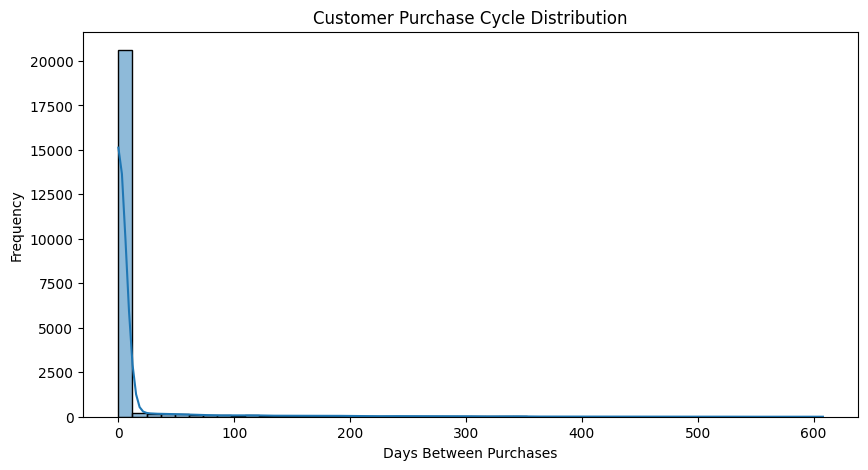

In [168]:
# 고객별 구매 주기 계산
df_train['order_purchase_date'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.date
df_train['order_purchase_datetime'] = pd.to_datetime(df_train['order_purchase_timestamp'])  # datetime 형식 추가

purchase_cycle = df_train.sort_values(['customer_unique_id', 'order_purchase_datetime']).groupby('customer_unique_id')['order_purchase_datetime'].diff().dt.days

# 시각화 - 구매 주기 분포
plt.figure(figsize=(10, 5))
sns.histplot(purchase_cycle.dropna(), bins=50, kde=True)
plt.title('Customer Purchase Cycle Distribution')
plt.xlabel('Days Between Purchases')
plt.ylabel('Frequency')
plt.show()

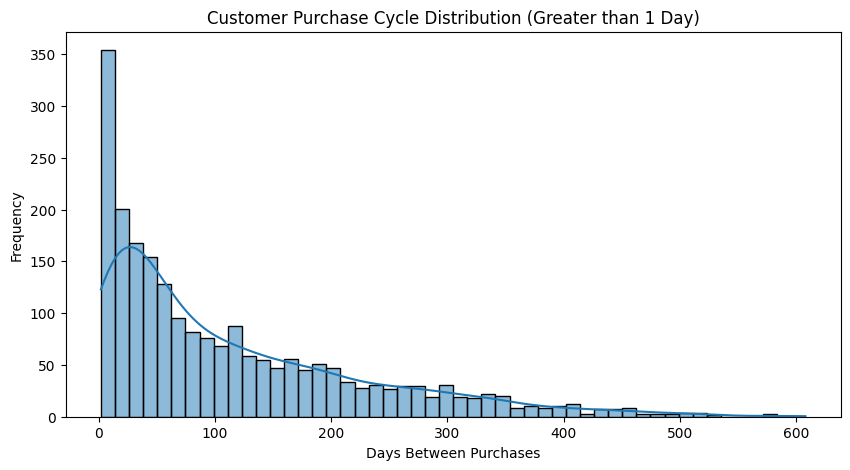

In [169]:
# 1일 이상인 값만 필터링
purchase_cycle_filtered = purchase_cycle[purchase_cycle > 1]

# 시각화 - 구매 주기 분포 (1일 이상)
plt.figure(figsize=(10, 5))
sns.histplot(purchase_cycle_filtered.dropna(), bins=50, kde=True)
plt.title('Customer Purchase Cycle Distribution (Greater than 1 Day)')
plt.xlabel('Days Between Purchases')
plt.ylabel('Frequency')
plt.show()

In [170]:
purchase_cycle_filtered.describe()

count    2179.000000
mean      114.117485
std       113.152728
min         2.000000
25%        25.000000
50%        73.000000
75%       172.000000
max       608.000000
Name: order_purchase_datetime, dtype: float64

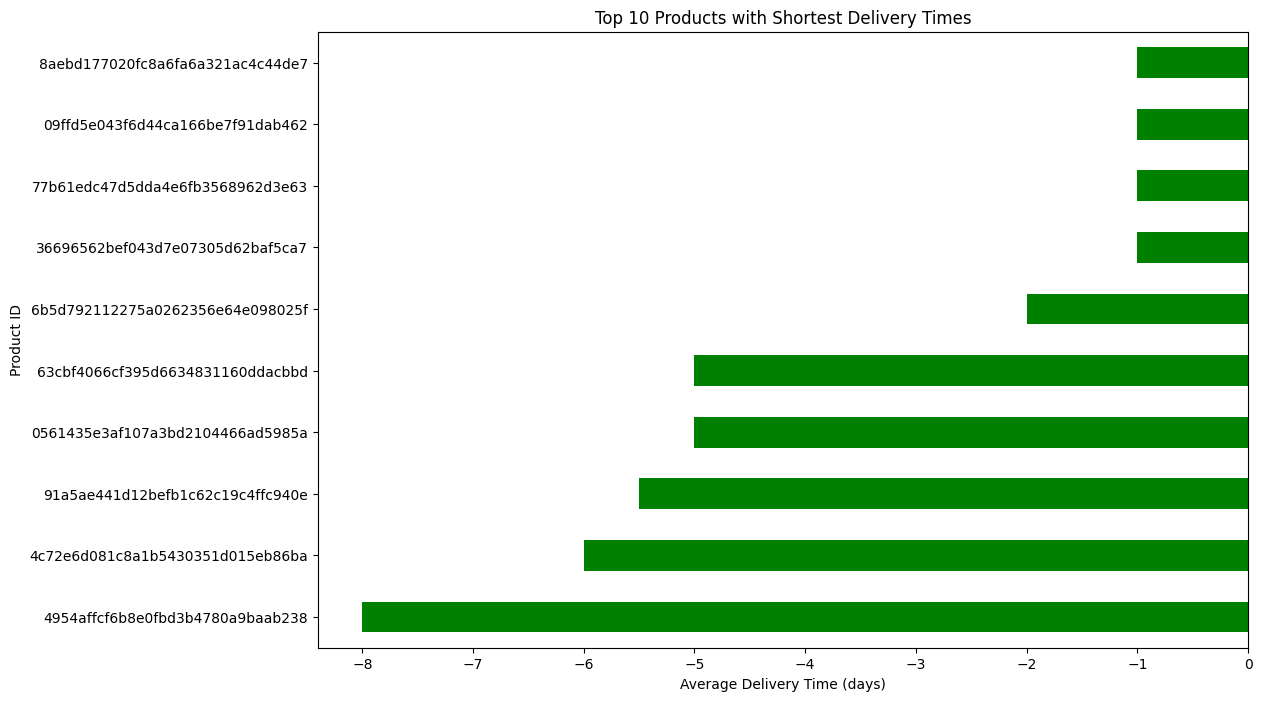

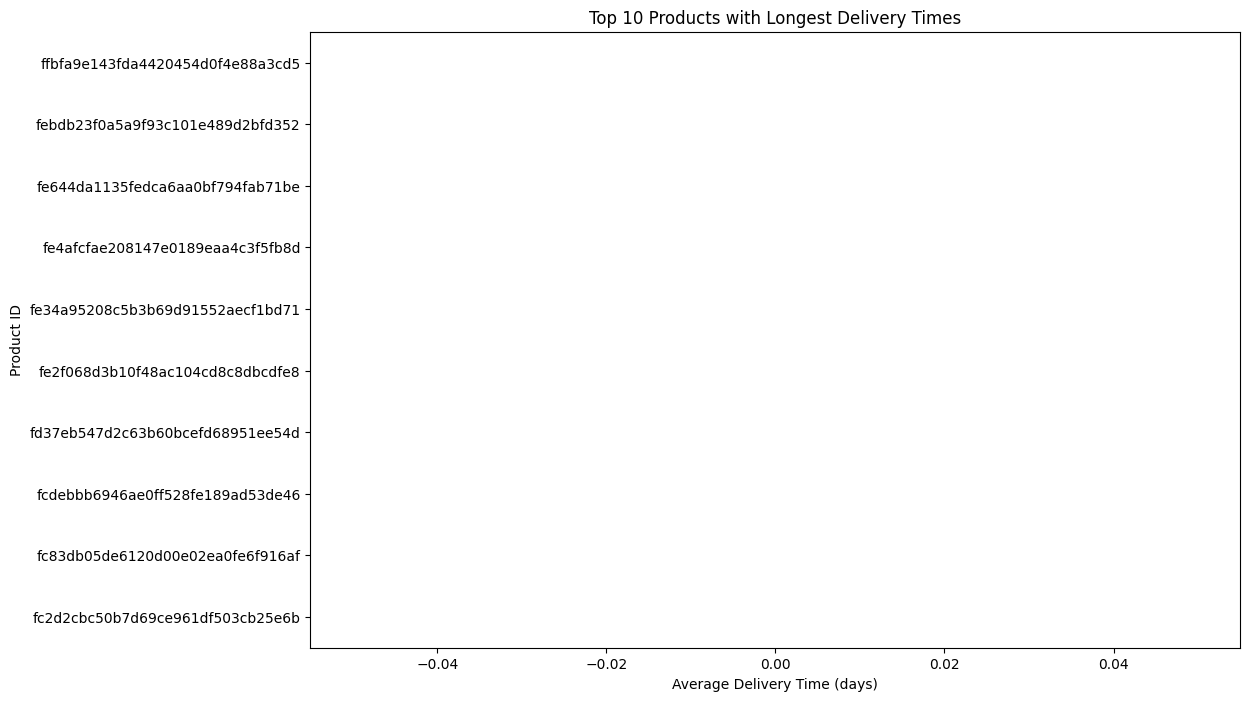

In [173]:
# 제품별 평균 배송 소요 시간 분석
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['order_delivered_carrier_date'] = pd.to_datetime(df_train['order_delivered_carrier_date'])

df_train['delivery_time'] = (df_train['order_delivered_customer_date'] - df_train['order_delivered_carrier_date']).dt.days
product_delivery_time = df_train.groupby('product_id')['delivery_time'].mean().sort_values()

# 시각화 - 상위 10개 및 하위 10개 제품 배송 소요 시간
plt.figure(figsize=(12, 8))
product_delivery_time.head(10).plot(kind='barh', color='green')
plt.title('Top 10 Products with Shortest Delivery Times')
plt.xlabel('Average Delivery Time (days)')
plt.ylabel('Product ID')
plt.show()

plt.figure(figsize=(12, 8))
product_delivery_time.tail(10).plot(kind='barh', color='red')
plt.title('Top 10 Products with Longest Delivery Times')
plt.xlabel('Average Delivery Time (days)')
plt.ylabel('Product ID')
plt.show()